## Time Series Forecasting with Streamed Data in Python

An example with Thymeboost

Online learning involves updating parameters with new data without re-fitting the entire process. For models which involve boosting, such as Thymeboost, the ability to pick up where we left off would save valuable computation time. 

Luckily for us, the boosting procedure unlocks an easy path to updating parameters given new data. This is because the whole system is built to learn from residuals. Once we have new data , we simply need to predict for that new data and inject those residuals back into the procedure. The rest flows normally from there!

### INTRODUCTION

In this article, we will take a quick look at the new 'update' method for Thymeboost which allows online learning to update the model as we receive new data. For example, we will generate a simple series which contains 2 trendchangepoints and some seasonality:

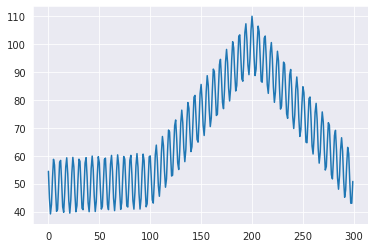

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style('darkgrid')

seasonality = ((np.cos(np.arange(1, 301))*10 + 50))
np.random.seed(100)
trend = np.linspace(-1,1,100)
trend = np.append(trend, np.linspace(1,50,100))
trend = np.append(trend, np.linspace(50,1,100))
y = trend + seasonality 
plt.plot(y)
plt.show()

With our series in hand, let's fit it in with Thymeboost the normal way. If you have not exposed to Thymeboost before, I recommend checking out this article which gives a good overview:

And make sure to have the most recent version from pip!
With that out of way, let's fit in:

In [17]:
pip install ThymeBoost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


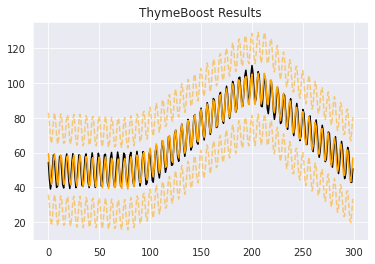

In [18]:
from ThymeBoost import ThymeBoost as tb
boosted_model = tb.ThymeBoost(verbose=0, n_rounds=None, split_strategy='gradient')
output = boosted_model.fit(y,
                           min_sample_pct=.2,
                           trend_estimator=['linear'],
                           seasonal_estimator='fourier',
                           seasonal_period=25,
                           additive=True,
                           global_cost='mse',
                           fit_type=['local'],
                           )
boosted_model.plot_results(output)

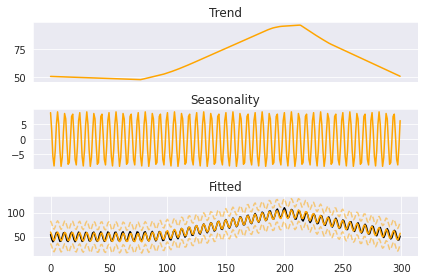

In [19]:
boosted_model.plot_components(output)

I won't spend much time on the different parameters, just remember that fit_type='local' means that we are searching for the change points. 

Overall, looks like we receive a reasobale fit. Could improve the results by increasing the number of proposals splits to try, but this visually looks ok. 

Now that we see what a 'full' fit of the series looks like, let's try out the new 'update' method which is the online learning piece.

First, we will do our standard fit but with just 100 values:

In [20]:
boosted_model = tb.ThymeBoost(verbose=0, 
                              split_strategy='gradient')
output= boosted_model.fit(y[:100],
                          min_sample_pct=.2,
                          trend_estimator=['linear'],
                          seasonal_estimator='fourier',
                          seasonal_period=25,
                          additive=True,
                          global_cost='maicc',
                          fit_type=['global', 'local'],
                          )

Next, let's get the next batch of data to update the model with. We will call this 'update_y' for obvious reasons!

In [23]:
update_y = y[100:150]

And finally, let's update the model with the 'update' method. All it takes is the output from the fit function and the updated series. Notice how I overwrite the output variable. The output of the update method is the same as the fit method:

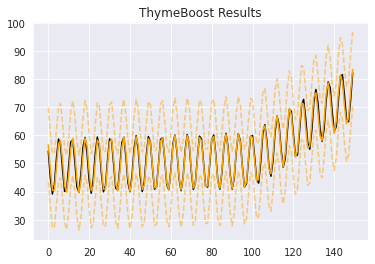

In [24]:
output = boosted_model.update(output, update_y)
boosted_model.plot_results(output)

As noted, the update method allows us to use all the standard methods that fit does, such as 'plot_results', ;plot_components', and 'predict'. Let's see the components:

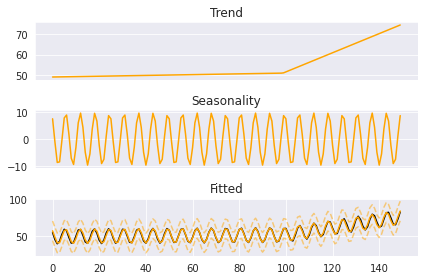

In [25]:
boosted_model.plot_components(output)

The results so far look good! We will usually not get identical results as a 'full' fit. This is due to the splits we consider when doing changepoint detection, and a few other nuances. But, the results should be comparable.  

Let's update the model again with the next 100 data points:

In [26]:
update_y = y[150:250]
output = boosted_model.update(output, update_y)

And finally we will use this to predict 25 steps:

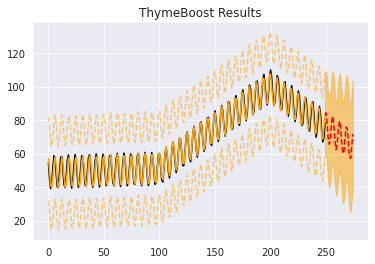

In [27]:
predicted_output = boosted_model.predict(output, 25)
boosted_model.plot_results(output, predicted_output)

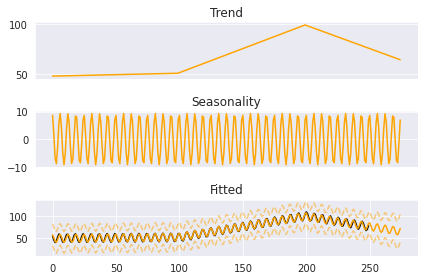

In [28]:
# And plotting components as before:
boosted_model.plot_components(output, predicted_output)

There we have it! A good fit from several updates and reasonable looking forecast. Few points to note:
1. First off, min_sample_pct = .2 applies to the series, so if you require the model to be more reactive then decrease that value to the appropriate level such as 0.05. 
2. Not everything we pass to the fit method will work in the update method. The most important of these being multiplicative fitting and passing exogenous variable.  